Using device: cuda


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/22381 [00:00<?, ? examples/s]

Map:   0%|          | 0/2797 [00:00<?, ? examples/s]

Map:   0%|          | 0/2799 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_19206/2542785994.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.116200,0.113496,0.968180,0.973607,0.961622,0.967577
2,0.057200,0.135081,0.966393,0.986395,0.944967,0.965237
3,0.054700,0.146162,0.970325,0.973723,0.965967,0.969829
4,0.021300,0.163410,0.968538,0.982823,0.952933,0.967647
5,0.007500,0.175012,0.970325,0.972344,0.967415,0.969873


Evaluation Results on Test Set: {'eval_loss': 0.10472902655601501, 'eval_accuracy': 0.9692747409789211, 'eval_precision': 0.9696969696969697, 'eval_recall': 0.968299711815562, 'eval_f1': 0.9689978370583995, 'eval_runtime': 16.4548, 'eval_samples_per_second': 170.102, 'eval_steps_per_second': 10.635, 'epoch': 5.0}
Test Metrics - Accuracy: 0.9692747409789211, Precision: 0.9696969696969697, Recall: 0.968299711815562, F1: 0.9689978370583995


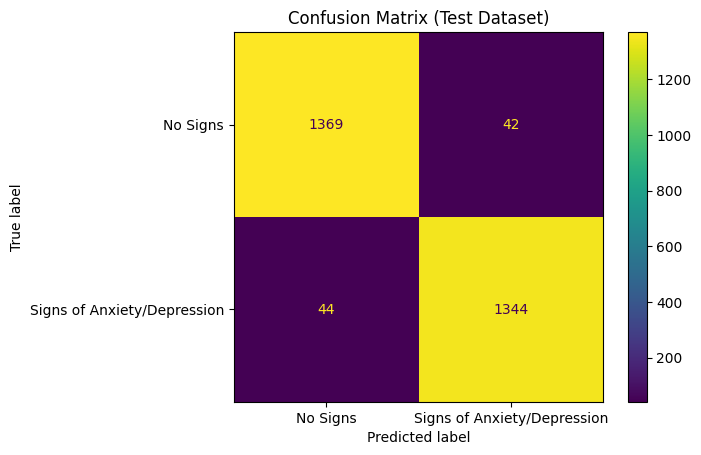

In [3]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import os

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
data = pd.read_csv("mental_health.csv")  # Replace with your file path

# Ensure required columns exist
if not {"text", "label"}.issubset(data.columns):
    raise KeyError("The dataset must contain 'text' and 'label' columns.")

# Convert the dataset to a Hugging Face Dataset
dataset = Dataset.from_pandas(data)

# Split into train, validation, and test sets
total_samples = len(dataset)
train_size = max(1, int(0.8 * total_samples))
valid_size = max(1, int(0.1 * total_samples))
test_size = total_samples - train_size - valid_size

train_dataset = dataset.select(range(train_size))
valid_dataset = dataset.select(range(train_size, train_size + valid_size))
test_dataset = dataset.select(range(train_size + valid_size, total_samples))

# Tokenizer (BERTweet-specific)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Tokenize datasets
tokenized_datasets = DatasetDict({
    "train": train_dataset.map(tokenize_function, batched=True),
    "validation": valid_dataset.map(tokenize_function, batched=True),
    "test": test_dataset.map(tokenize_function, batched=True)
})

# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model (BERTweet-specific)
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)
model = model.to(device)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",  # Directory for logs
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    logging_steps=50  # Log every 50 steps
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), axis=1).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Custom Callback for Saving Logs
from transformers import TrainerCallback

class SaveTrainingLogsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            os.makedirs("./logs", exist_ok=True)
            with open("./logs/custom_trainer_state.json", "a") as f:
                f.write(str(logs) + "\n")

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[SaveTrainingLogsCallback()]  # Add custom callback
)

# Train the model
trainer.train()

# Evaluate on test set
results = trainer.evaluate(tokenized_datasets["test"])
print("Evaluation Results on Test Set:", results)

# Generate Confusion Matrix
predictions = trainer.predict(tokenized_datasets["test"])
y_true = predictions.label_ids
y_pred = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# Metrics on test dataset
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Confusion Matrix for test dataset
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Signs", "Signs of Anxiety/Depression"])
disp.plot(cmap="viridis")
plt.title("Confusion Matrix (Test Dataset)")
plt.show()

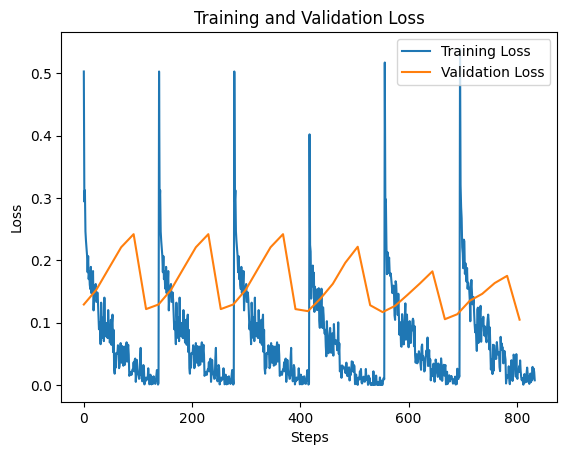

In [4]:
# Training and Validation Loss Plot
if os.path.exists("./logs/custom_trainer_state.json"):
    with open("./logs/custom_trainer_state.json", "r") as f:
        logs = [eval(line) for line in f.readlines()]
    training_loss = [log["loss"] for log in logs if "loss" in log]
    validation_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
    steps = range(len(training_loss))  # Steps for training loss

    # Ensure validation_steps matches validation_loss length
    validation_steps = range(0, len(training_loss), max(1, len(training_loss) // len(validation_loss)))[:len(validation_loss)]

    plt.plot(steps, training_loss, label="Training Loss")
    if validation_loss:
        plt.plot(validation_steps, validation_loss, label="Validation Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()
else:
    print("Log file not found. Cannot plot training and validation loss.")
